In [62]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import glob
import pandas as pd

plt.style.use('seaborn-whitegrid')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

categories_in_data = ['bicycle', 'phone', 'helmet', 'airbag_helmet']
categories_lookup = dict(zip(categories_in_data, range(len(categories_in_data))))

In [63]:
config_path='config/yolov3.cfg'
class_path='config/coco.names'
img_size=416

# Load Models and Weights

## bicycle
weights_path_bicycle='checkpoints/bicycle/bicycle.weights'
conf_thres_bicycle=0.9
nms_thres_bicycle=0.2

model_bicycle = Darknet(config_path, img_size=img_size)
model_bicycle.load_weights(weights_path_bicycle)
if torch.cuda.is_available():
  model_bicycle.cuda()
model_bicycle.eval()

## helmet
weights_path_helmet='checkpoints/helmet/90.weights'
conf_thres_helmet=0.8
nms_thres_helmet=0.2

model_helmet = Darknet(config_path, img_size=img_size)
model_helmet.load_weights(weights_path_helmet)
if torch.cuda.is_available():
  model_helmet.cuda()
model_helmet.eval()

classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

/zhome/79/4/146412/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [64]:
def detect_image(model, conf_thres, nms_thres, img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
         transforms.Pad((max(int((imh-imw)/2),0), 
              max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
              max(int((imw-imh)/2),0)), (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, 
                        conf_thres, nms_thres)
    return detections[0]

In [65]:
# load image and get detections
directories_to_look_in = ["dummy_data/helmet/images/", "dummy_data/bicycle/images/"]
class_count = {}
plot = True
save = False

img_paths = []
dir_files = []
for dir in directories_to_look_in:
    dir_files = glob.glob(dir + "*")
    img_paths += dir_files
img_paths = list(img_paths)

/zhome/79/4/146412/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

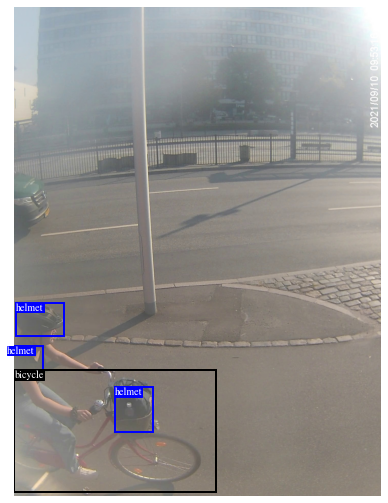

<Figure size 432x288 with 0 Axes>

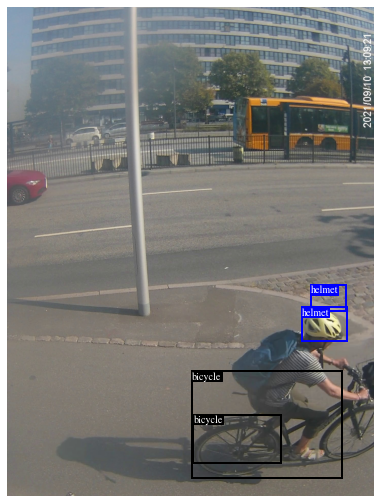

<Figure size 432x288 with 0 Axes>

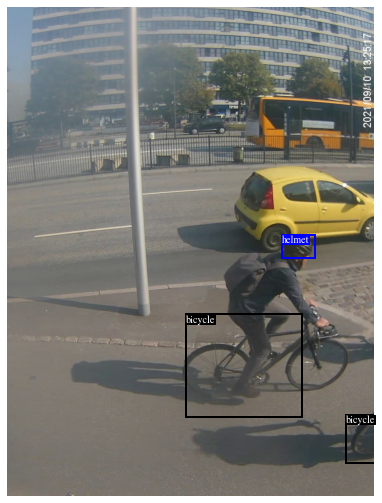

<Figure size 432x288 with 0 Axes>

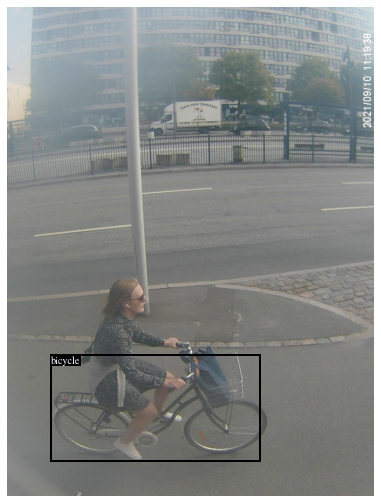

<Figure size 432x288 with 0 Axes>

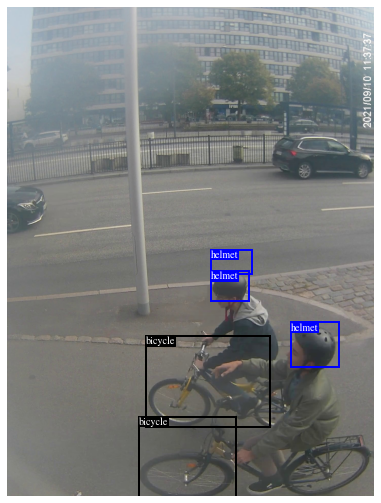

<Figure size 432x288 with 0 Axes>

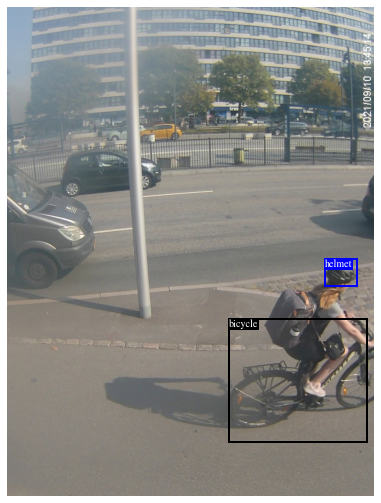

<Figure size 432x288 with 0 Axes>

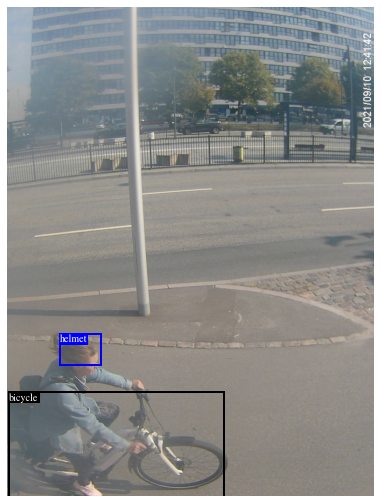

<Figure size 432x288 with 0 Axes>

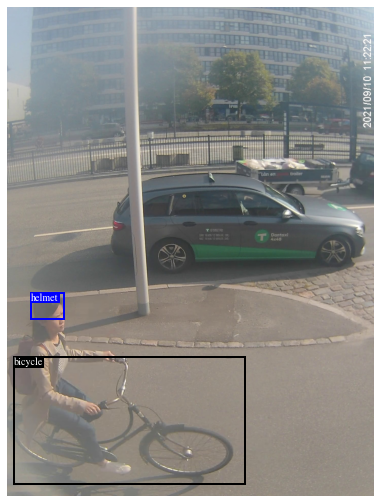

<Figure size 432x288 with 0 Axes>

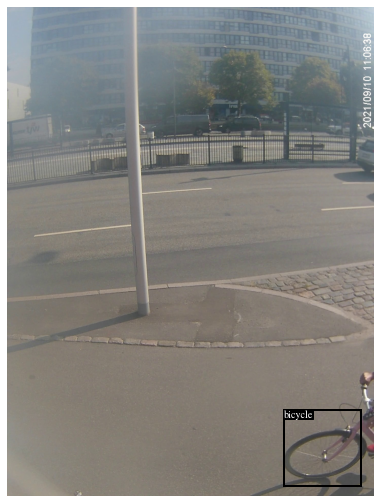

<Figure size 432x288 with 0 Axes>

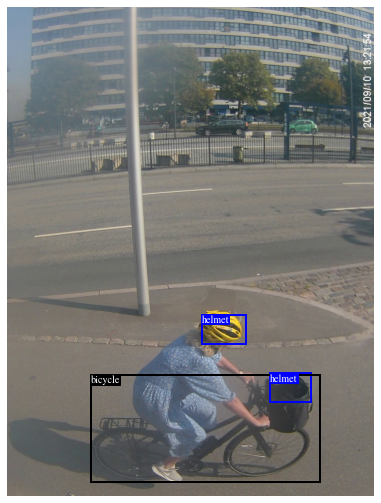

<Figure size 432x288 with 0 Axes>

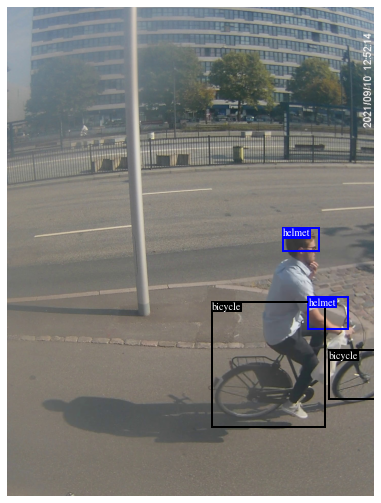

<Figure size 432x288 with 0 Axes>

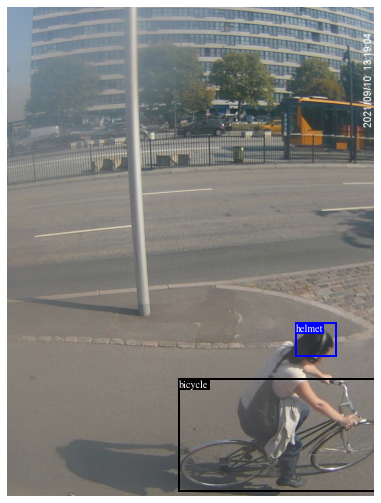

<Figure size 432x288 with 0 Axes>

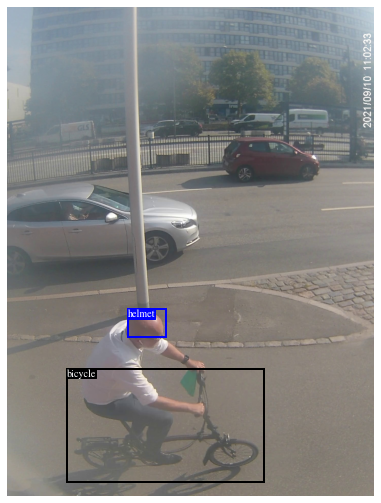

<Figure size 432x288 with 0 Axes>

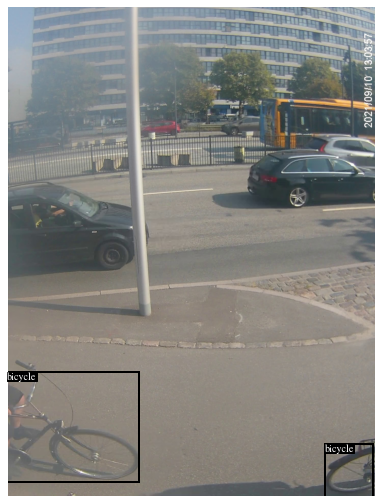

In [66]:
for img_path in img_paths:
    prev_time = time.time()
    img = Image.open(img_path)
    
    detections_bicycle =  detect_image(model_bicycle, conf_thres_bicycle, nms_thres_bicycle, img)
    detections_helmet =  detect_image(model_helmet, conf_thres_helmet, nms_thres_helmet, img)
    
    
    det_list = []
    for det in [detections_helmet, detections_bicycle]:
        if det != None:
            det_list.append(det)
    try:
        detections = torch.cat(det_list)
    except:
        detections = None

    inference_time = datetime.timedelta(seconds=time.time() - prev_time)

    bbox_colors = {'bicycle': 'k', 'helmet': 'b', 'phone': 'r', 'airbag_helmet': 'g'}
    img = np.array(img)

    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        # browse detections and draw bounding boxes
        img_pred_classes = []
        with open("val_predictions/" + img_path.split("/")[-1].split(".")[0] + ".txt", "w+") as f:
            for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                img_pred_classes.append(int(cls_pred)) # for stats

                box_h = ((y2 - y1) / unpad_h) * img.shape[0]
                box_w = ((x2 - x1) / unpad_w) * img.shape[1]
                if classes[int(cls_pred)] == 'bicycle':  
                    y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0] + box_h/2 # trained model with corner xy instead of middle
                    x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1] + box_w/2 # trained model with corner xy instead of middle
                else:
                    y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
                    x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
                color = bbox_colors[classes[int(cls_pred)]]
                bbox = patches.Rectangle((x1, y1), box_w, box_h,
                        linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(bbox)
                plt.text(x1, y1, s=classes[int(cls_pred)], 
                        color='white', verticalalignment='top',
                        bbox={'color': color, 'pad': 0})

    plt.axis('off')
    